###### working directory: G:\My Drive\Data\Voting Age Data Census 2018 5yr\Notebooks

In [1]:
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import shapely
import shapely.geometry as sg
import folium
import geojson
import fiona
import mapclassify

import matplotlib.cm as cm, matplotlib.font_manager as fm
from datetime import datetime as dt
from shapely.geometry import Polygon
from geopy.distance import great_circle
from geopandas import GeoDataFrame
import descartes
import pysal

%matplotlib inline

##### Goal: convert a shapefile to geojson
Steps:
 1. read shapefile
 2. convert shapefile to geojson
 3. merge new geojson file with tabular data
 4. export geo file with voter data

### Read in a shapefile with geopandas  and create json file

#### read in shapefile

In [2]:
gdf_filea = gpd.read_file('G:\My Drive\Data\CA Congress Dist 50\Geo_Files\Congress_Shapefile\CA_Congress_Dist_50_CT.shp')

#### create json file

In [3]:
gdf_filea.to_file('G:\My Drive\Data\CA Congress Dist 50\Geo_Files\CA_Congress.json', driver='GeoJSON')

#### read in json file

In [4]:
gdf_filea = gpd.read_file('G:\My Drive\Data\CA Congress Dist 50\Geo_Files\CA_Congress.json')

In [5]:
type(gdf_filea)

geopandas.geodataframe.GeoDataFrame

#### plot json file

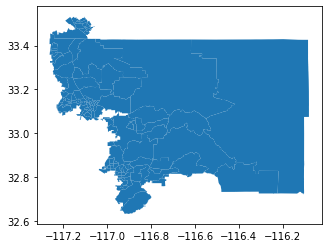

In [6]:
gdf_filea.plot()

#### explicitly setting the index to geoid

In [7]:
gdf_file = gdf_filea[['GEOID','geometry']].set_index('GEOID')
gdf_file.head(2)

,geometry
GEOID,
06065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
06065049600,"POLYGON ((-117.16311 33.52238, -117.16311 33.5..."


##### Reading data for voters over 18, then merging this with the geodataframe. 

In [8]:
#specify datatypes so GEOID reads in properly
variable_types = {'GEOID': 'str'}

# reading in tabular data
df_popa = pd.read_csv('G:\My Drive\Data\Voting Age Data Census 2018 5yr\Data_Exports\eligible_voters_over_18.csv', delimiter = ',', dtype=variable_types)
df_popa.head(1)


,GEOID,NAME,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County
0,06065043216,"Census Tract 432.16, Riverside County, California",4331,437,1343,366,31.0,6.9,2988,69.0,CT 432.16,Riverside


#### Creating another df for viz at the end of the notebook

In [9]:
#specify datatypes so GEOID reads in properly
variable_types = {'GEOID': 'str'}

# reading in tabular data
df_density = pd.read_csv(r'G:\My Drive\Data\Density 2017\Data_Exports\density.csv', delimiter = ',', dtype=variable_types)

# pad a string with leading zeros.
df_density['GEOID'] = df_density['GEOID'].str.zfill(11)

#Dropping these columns 
df_density=df_density.drop(['Census Tract', 'County'], axis = 1)

df_density.head(1)

,GEOID,total_pop,pop_density,density_abv_average
0,06065043216,6359,3215.163,0


In [10]:
# Joining voting age data to density data
df_voteage_den = pd.merge(df_density, df_popa, on='GEOID', how='inner')


In [11]:
df_voteage_den

,GEOID,total_pop,pop_density,density_abv_average,NAME,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County
0,06065043216,6359,3215.16300,0,"Census Tract 432.16, Riverside County, California",4331,437,1343,366,31.0,6.9,2988,69.0,CT 432.16,Riverside
1,06065043218,5415,2814.28200,0,"Census Tract 432.18, Riverside County, California",4002,338,959,221,24.0,4.4,3043,76.0,CT 432.18,Riverside
2,06065043220,4480,6523.11100,1,"Census Tract 432.20, Riverside County, California",2970,300,952,252,32.1,6.4,2018,67.9,CT 432.20,Riverside
3,06065043222,4570,1353.67000,0,"Census Tract 432.22, Riverside County, California",3591,275,552,147,15.4,3.8,3039,84.6,CT 432.22,Riverside
4,06065043246,5706,1140.14600,0,"Census Tract 432.46, Riverside County, California",4145,393,767,200,18.5,3.6,3378,81.5,CT 432.46,Riverside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,06073021205,7073,1844.53100,0,"Census Tract 212.05, San Diego County, California",5225,611,1287,426,24.6,6.4,3938,75.4,CT 212.05,San Diego
155,06073021206,3065,187.84120,0,"Census Tract 212.06, San Diego County, California",2505,219,286,111,11.4,4.1,2219,88.6,CT 212.06,San Diego
156,06073021302,7738,53.09579,0,"Census Tract 213.02, San Diego County, California",6147,555,1643,297,26.7,3.4,4504,73.3,CT 213.02,San Diego
157,06073021303,9497,319.79820,0,"Census Tract 213.03, San Diego County, California",6304,637,775,286,12.3,3.9,5529,87.7,CT 213.03,San Diego


In [12]:
# Joining voting age data to density data
df_voteage_den['pct_of_voters'] = df_voteage_den['tot_ovr_18'] / df_voteage_den['total_pop'] * 100

#Dropping these columns 
df_voteage_den=df_voteage_den.drop(['NAME'], axis = 1)

df_popa = df_voteage_den
df_popa.head(2)

,GEOID,total_pop,pop_density,density_abv_average,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County,pct_of_voters
0,06065043216,6359,3215.163,0,4331,437,1343,366,31.0,6.9,2988,69.0,CT 432.16,Riverside,68.108193
1,06065043218,5415,2814.282,0,4002,338,959,221,24.0,4.4,3043,76.0,CT 432.18,Riverside,73.905817


#### explicitly setting the index to geoid

In [13]:
df_pop = df_popa.set_index('GEOID')

### Joining the geodataframe to tabular data

###### Attribute joins are accomplished using the merge method. In general, it is recommended to use the merge method called from the spatial dataset. With that said, the stand-alone merge function will work if the GeoDataFrame is in the left argument; if a DataFrame is in the left argument and a GeoDataFrame is in the right position, the result will no longer be a GeoDataFrame.

##### example:  new_gpdf = country_shapes.merge(country_names, on='key')

In [14]:
# Joining voter data to geodataframe
gdf_w_voter = gdf_file.merge( df_pop, on='GEOID')


In [15]:
# # save file as csv with data and geo
gdf_w_voter.to_csv(r'G:\My Drive\Data\Voting Age Data Census 2018 5yr\Data_Exports\voter_w_geo.csv')

gdf_w_voter.head(1)

,geometry,total_pop,pop_density,density_abv_average,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County,pct_of_voters
GEOID,,,,,,,,,,,,,,,
06065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",4002,162.4045,0,2856,333,849,293,29.7,7.7,2007,70.3,CT 512,Riverside,71.364318


#### create json file

In [16]:
gdf_w_voter.to_file('G:\My Drive\Data\Voting Age Data Census 2018 5yr\Geo_Files\CA_50_w_voter_dat.json', driver='GeoJSON')

#### read in json file

In [17]:
gdf_w_voter = gpd.read_file('G:\My Drive\Data\Voting Age Data Census 2018 5yr\Geo_Files\CA_50_w_voter_dat.json')

In [18]:
type(gdf_filea)

geopandas.geodataframe.GeoDataFrame

#### plot json file

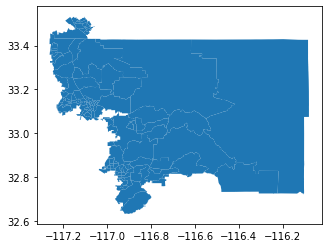

In [19]:
gdf_w_voter.plot()

In [20]:
gdf_w_voter.head(2)

,GEOID,total_pop,pop_density,density_abv_average,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County,pct_of_voters,geometry
0,06065051200,4002,162.4045,0,2856,333,849,293,29.7,7.7,2007,70.3,CT 512,Riverside,71.364318,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
1,06065049600,8407,5654.9680,1,5174,391,993,232,19.2,3.9,4181,80.8,CT 496,Riverside,61.543951,"POLYGON ((-117.16311 33.52238, -117.16311 33.5..."


In [21]:
df_subset = gdf_w_voter[['total_pop', 'pop_density', 'pct_18_29', 'pct_ovr_30','pct_of_voters',]]

In [22]:
gdf_w_voter.columns

Index(['GEOID', 'total_pop', 'pop_density', 'density_abv_average',
       'tot_ovr_18', 'tot_ovr_18_moe', 'tot_18_29', 'tot_18_29_moe',
       'pct_18_29', 'pct_18_29_moe', 'tot_ovr_30', 'pct_ovr_30',
       'Census Tract', 'County', 'pct_of_voters', 'geometry'],
      dtype='object')

In [23]:
df_subset.describe()

,total_pop,pop_density,pct_18_29,pct_ovr_30,pct_of_voters
count,159.000000,159.000000,159.000000,159.000000,159.000000
mean,5927.817610,4519.023514,22.481132,77.518868,68.873039
std,3590.341156,5398.962128,9.571127,9.571127,11.454098
min,1600.000000,3.247912,7.700000,16.900000,24.218230
25%,4008.000000,587.000950,16.750000,73.200000,63.890626
50%,5599.000000,3085.665000,20.700000,79.300000,71.634911
75%,7143.500000,5889.834500,26.800000,83.250000,75.154329
max,40402.000000,30085.250000,83.100000,92.300000,94.010152


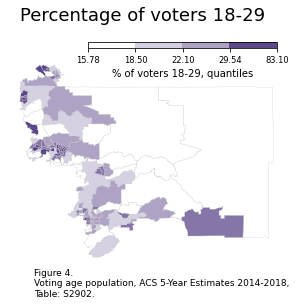

In [24]:

fig, ax = plt.subplots(1, figsize=(5, 4.5))
ax.axis('off')

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', ["#FFFFFF", "#D6D1E2", "#AEA3C4", "#8575A8", "#5D478B"], 5)

gdf_w_voter.plot(cmap=cmap, scheme='quantiles', ax=ax, column='pct_18_29', linewidth=0.3, edgecolor='0.8')

# The tick marks we want for our map.  We'll pull these directly from the mapclassify code.
bounds = list(mapclassify.Quantiles(gdf_w_voter['pct_18_29'], k=5).bins)

# This controls how the colors are scaled using the above bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

# This sets where the colorbar goes and its size
cbax = fig.add_axes([.35, .85, 0.525, 0.02])

cb2 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, ticks=bounds, orientation='horizontal')

cb2.set_label(r'% of voters 18-29, quantiles')
cb2.ax.xaxis.set_label_position('bottom')
cb2.ax.xaxis.label.set_multialignment('left')
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

# add a title
fig.suptitle('Percentage of voters 18-29', fontsize=18, fontweight= 3)

# add a footnote
plt.figtext(.2, .08, r'Figure 4.'  + "\n" +  'Voting age population, ACS 5-Year Estimates 2014-2018, '  + "\n" +  'Table: S2902.',
             ha='left', va='bottom', fontsize=9)

#this will save the figure as a high-res png. you can also save as svg
fig.savefig(r'G:\My Drive\Data\CA Congressional District_Compilation\Graphs\GoogleDoc_18_29_and_over.png', 
            bbox_inches='tight',pad_inches=0.1, dpi=200)

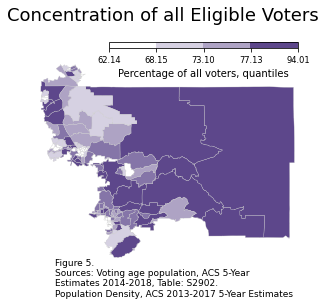

In [25]:

fig, ax = plt.subplots(1, figsize=(5, 4.5))
ax.axis('off')

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', ["#FFFFFF", "#D6D1E2", "#AEA3C4", "#8575A8", "#5D478B"], 5)

gdf_w_voter.plot(cmap=cmap, scheme='quantiles', ax=ax, column='pct_of_voters', linewidth=0.3, edgecolor='0.8')

# The tick marks we want for our map.  We'll pull these directly from the mapclassify code.
bounds = list(mapclassify.Quantiles(gdf_w_voter['pct_of_voters'], k=5).bins)

# This controls how the colors are scaled using the above bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, clip=True)

# This sets where the colorbar goes and its size
cbax = fig.add_axes([.35, .85, 0.525, 0.02])

cb2 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap, norm=norm, ticks=bounds, orientation='horizontal')

cb2.set_label(r'Percentage of all voters, quantiles')
cb2.ax.xaxis.set_label_position('bottom')
cb2.ax.xaxis.label.set_multialignment('left')
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

# add a title
fig.suptitle('Concentration of all Eligible Voters', fontsize=18, fontweight= 3)

# add a footnote
plt.figtext(.2, .08, r'Figure 5.'  + '\n' +  'Sources: Voting age population, ACS 5-Year '  + '\n' +   
            'Estimates 2014-2018, Table: S2902.' + '\n' +   'Population Density, ACS 2013-2017 5-Year Estimates', ha='left', va='bottom', fontsize=9)

#this will save the figure as a high-res png. you can also save as svg
fig.savefig(r'G:\My Drive\Data\CA Congressional District_Compilation\Graphs\GoogleDoc_Eligible_voters.png', 
            bbox_inches='tight',pad_inches=0.1, dpi=200)

In [26]:
gdf_w_voter.head(1)

,GEOID,total_pop,pop_density,density_abv_average,tot_ovr_18,tot_ovr_18_moe,tot_18_29,tot_18_29_moe,pct_18_29,pct_18_29_moe,tot_ovr_30,pct_ovr_30,Census Tract,County,pct_of_voters,geometry
0,06065051200,4002,162.4045,0,2856,333,849,293,29.7,7.7,2007,70.3,CT 512,Riverside,71.364318,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
